In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

### 1D Ising model with 2 sites and hopping term

In [4]:
## Physical quantaties
J = 0.5
h = 1

## Gates
Z = np.array([[1,0],[0,-1]])
X = np.array([[0,1],[1,0]])
I = np.identity(2)

## States
state_0 = np.array([1,0])
state_1 = np.array([0,1])

state_0a = np.kron(state_0, state_0)
state_0b = np.kron(state_0, state_1)
state_1a = np.kron(state_1, state_0)
state_1b = np.kron(state_1, state_1)

## Projections
proj_0a = np.outer(state_0a, state_0a)
proj_0b = np.outer(state_0b, state_0b)
proj_1a = np.outer(state_1a, state_1a)
proj_1b = np.outer(state_1b, state_1b)

## Hamiltonian
H = 'J * np.kron(Z, Z) + h * np.kron(X, I) + h * np.kron(I, X)'

['J * np.kron(Z, Z) ', ' h * np.kron(X, I) ', ' h * np.kron(I, X)']

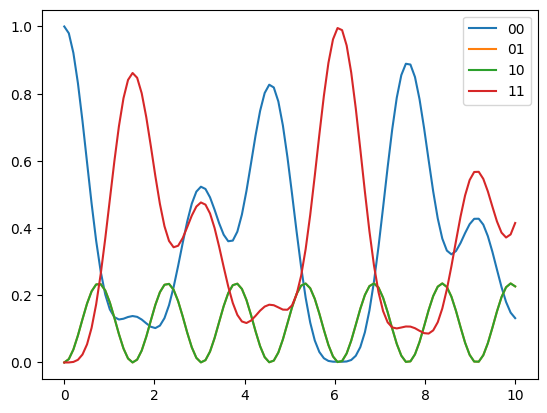

In [72]:
## Exact time evolution
H_exact = eval(H)
initial_state = state_0a

t_max = 10
dt = 0.1
t = np.linspace(0, t_max, int(t_max/dt))
t = t[...,None, None]                        #reshape to be able to broadcast into H

U_exact = expm(-1j*H_exact*t)

psi_t = U_exact @ initial_state

probs = np.abs(psi_t)**2

exact_0a = np.linalg.norm(proj_0a @ psi_t[...,None], axis=1)**2
exact_0b = np.linalg.norm(proj_0b @ psi_t[...,None], axis=1)**2
exact_1a = np.linalg.norm(proj_1a @ psi_t[...,None], axis=1)**2
exact_1b = np.linalg.norm(proj_1b @ psi_t[...,None], axis=1)**2

plt.plot(t[:,0], exact_0a, label = '00')
plt.plot(t[:,0], exact_0b, label = '01')
plt.plot(t[:,0], exact_1a, label = '10')
plt.plot(t[:,0], exact_1b, label = '11')

plt.legend()

array([1., 0., 0., 0.])

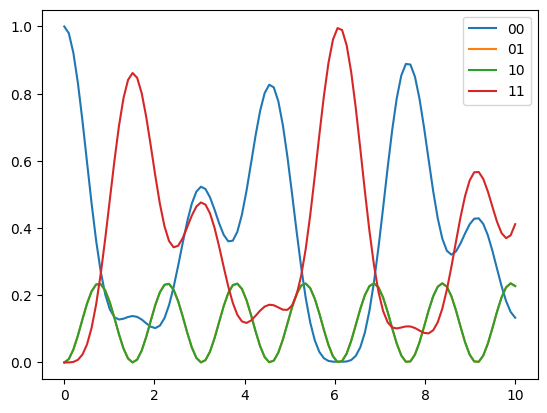

In [118]:
## Trotterization
initial_state = state_0a                     #Set initial state equal to 00

n = 100                                        #number of Trotter steps
t_max = 10
dt = 0.1
t = np.linspace(0, t_max, int(t_max/dt))
t = t[...,None, None]                        #reshape to be able to broadcast into H

# Split the Hamiltonian and create unitaries
for i, term in enumerate(H.split('+')):
    globals()[f"U_{i}"] = expm(-1j*eval(term)*t/n)

U_t = (U_0 @ U_1 @ U_2)
#Repeat for number of Trotter steps
for i in range(n - 1):
    U_t = U_t @ (U_0 @ U_1 @ U_2)

psi_t = U_t @ initial_state

trotter_0a = np.linalg.norm(proj_0a @ psi_t[...,None], axis=1)**2
trotter_0b = np.linalg.norm(proj_0b @ psi_t[...,None], axis=1)**2
trotter_1a = np.linalg.norm(proj_1a @ psi_t[...,None], axis=1)**2
trotter_1b = np.linalg.norm(proj_1b @ psi_t[...,None], axis=1)**2

plt.plot(t[:,0], trotter_0a, label = '00')
plt.plot(t[:,0], trotter_0b, label = '01')
plt.plot(t[:,0], trotter_1a, label = '10')
plt.plot(t[:,0], trotter_1b, label = '11')

plt.legend()

In [122]:
np.mean(1/4 * np.trace(U_t.conjugate().transpose(0,2,1) @ U_exact, axis1 = 1, axis2 = 2))

np.complex128(0.9998944541350477-1.2394599235854287e-17j)

In [124]:
len(U_t[0])

4

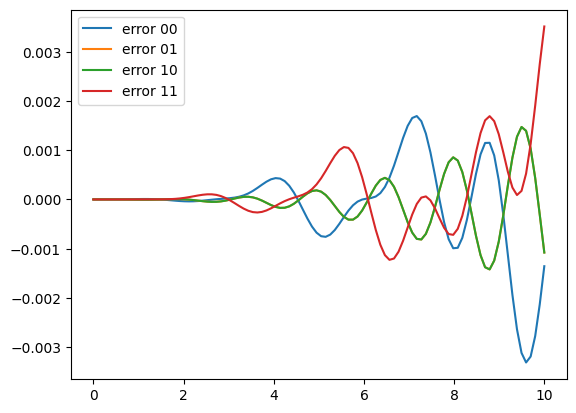

In [121]:
plt.plot(t[:,0], exact_0a - trotter_0a, label = 'error 00')
plt.plot(t[:,0], exact_0b - trotter_0b, label = 'error 01')
plt.plot(t[:,0], exact_1a - trotter_1a, label = 'error 10')
plt.plot(t[:,0], exact_1b - trotter_1b, label = 'error 11')

plt.legend()

In [248]:
## Physical quantaties
J = 0.5
h = 1

#Ising Hamiltonian for 2 sites
hamiltonian = 'J * np.kron(Z, Z) + h * np.kron(X, I) + h * np.kron(I, X)'

initial_state = state_0a   

t = np.linspace(0, t_max, int(t_max/dt))
t = t[...,None, None]                        #reshape to be able to broadcast into H
time = t[:,0]

#trotter time evolution
trotter_steps = 20

U_terms = []
H_terms = hamiltonian.split('+')
#split the Hamiltonian and create unitaries
for i in range(len(H_terms)):
    if i < len(H_terms) - 1: #The last term in the sum needs not to have factor of two in denominator
        U_terms.append(expm(-1j * eval(H_terms[i]) * t / (2 * trotter_steps))) #the number of terms - 1 is the exponent for trotter steps
    else: 
        U_terms.append(expm(-1j * eval(H_terms[i]) * t / (trotter_steps)))

U_step = U_terms[-1]  #inner most matrix / last term in sum
for i in range(1,len(U_terms)):
    U_step = U_terms[-(1+i)] @ U_step @ U_terms[-(1+i)]

U_t = U_step
for i in range(trotter_steps - 1):
    U_t = U_t @ U_step

psi_t = U_t @ initial_state

probabilities_trotter2 = np.abs(psi_t)**2

#exact time evolution
H_exact = eval(hamiltonian)
        
U_exact = expm(-1j*H_exact*t)
        
psi_exact = U_exact @ initial_state
        
probabilities_exact = np.abs(psi_exact)**2


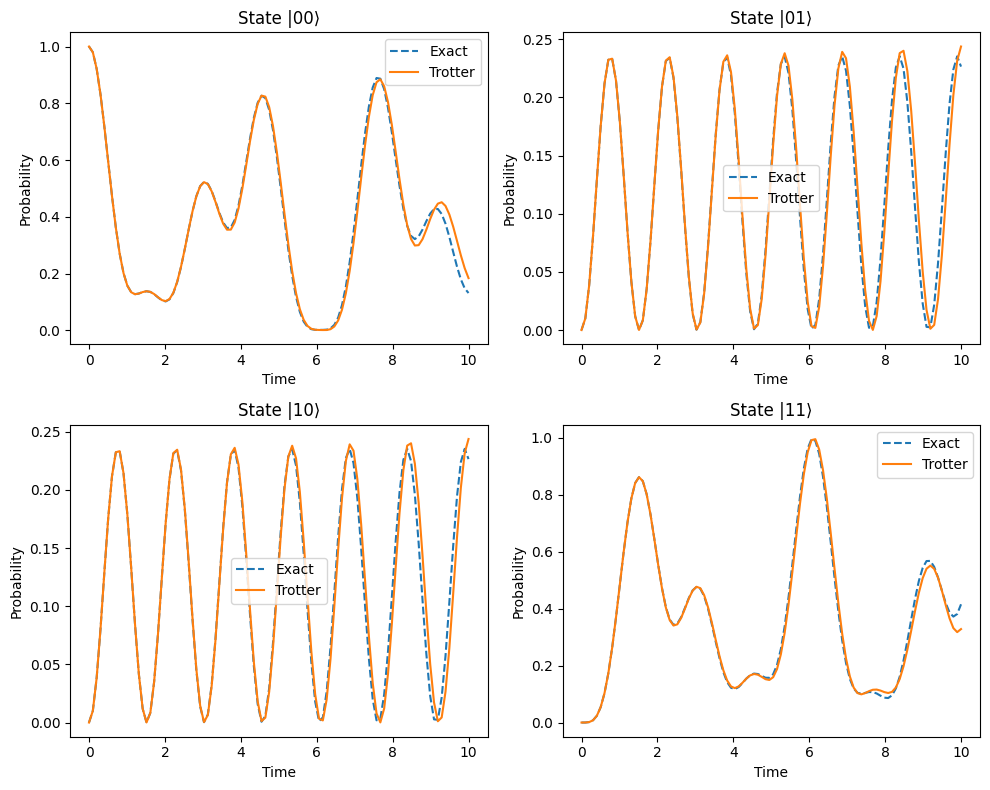

In [249]:
#plotting
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  
axes = axes.flatten()  #So we can index axes[0]..axes[3]

states = [format(i, f"0{2}b") for i in range(2**2)]  #Create a bit string for given state

for i, state in enumerate(states):
    ax = axes[i]
    ax.plot(time, probabilities_exact[:, i], label="Exact", linestyle="--")
    ax.plot(time, probabilities_trotter2[:, i], label="Trotter")
    ax.set_title(f"State |{state}⟩")
    ax.set_xlabel("Time")
    ax.set_ylabel("Probability")
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
     def trotter_step(dt):
            """One second-order Trotter step for small time dt."""
            # Forward half-steps for first n-1 terms
            U = np.eye(H_terms[0].shape[0], dtype=complex)
            for H in H_terms[:-1]:
                U = expm(-1j * H * dt / 2) @ U
            # Full step for last term
            U = expm(-1j * H_terms[-1] * dt) @ U
            # Backward half-steps
            for H in reversed(H_terms[:-1]):
                U = expm(-1j * H * dt / 2) @ U
            return U
    
        # Δt for each trotter step
        small_dt = dt / trotter_steps
    
        U_t_list = []
        psi_t_list = []
        for T in times:
            # Build U(T) by repeating small steps
            U_total = np.eye(H_terms[0].shape[0], dtype=complex)
            steps_needed = int(T / small_dt)
            for _ in range(steps_needed):
                U_total = trotter_step(small_dt) @ U_total
            psi_t = U_total @ initial_state
            U_t_list.append(U_total)
            psi_t_list.append(psi_t)
    
        probabilities = np.abs(np.array(psi_t_list))**2
        return probabilities, times, np.array(psi_t_list), np.array(U_t_list)
